## XGBoost - composite sensors - 2bins - 70/30

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(f"../DetectionResponseSensors_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_type         56 non-null     object 
 1   ZnO_content         56 non-null     int64  
 2   temperature         56 non-null     int64  
 3   sensing             56 non-null     float64
 4   sensing_2bins_5050  56 non-null     int64  
 5   sensing_7030        56 non-null     int64  
 6   sensor_conds        56 non-null     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ KB


In [3]:
df["sensor_type"].unique()

array(['core-shell', 'composite'], dtype=object)

In [4]:
target = "sensing_7030"
representation = ["sensor_type", "ZnO_content", "temperature"]
random_state=42
train_size=40

In [5]:
encoded_sensor_type = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoded_sensor_type.fit_transform(df[["sensor_type"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sensor_type             56 non-null     object 
 1   ZnO_content             56 non-null     int64  
 2   temperature             56 non-null     int64  
 3   sensing                 56 non-null     float64
 4   sensing_2bins_7030      56 non-null     int64  
 5   sensing_2bins_5050      56 non-null     int64  
 6   sensor_conds            56 non-null     object 
 7   sensor_type_composite   56 non-null     float64
 8   sensor_type_core-shell  56 non-null     float64
dtypes: float64(3), int64(4), object(2)
memory usage: 4.1+ KB


In [7]:
df.columns[7:9].to_list()

['sensor_type_composite', 'sensor_type_core-shell']

In [8]:
representation = ["ZnO_content", "temperature"]
representation.extend(df.columns[7:9].to_list())

In [9]:
representation

['ZnO_content',
 'temperature',
 'sensor_type_composite',
 'sensor_type_core-shell']

In [27]:
def prepare_dataset_classification(
    df,
    target = "sensing_7030",
    representation=representation,
    random_state=42,
    train_size=40
):
    df_train, df_val_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_val_test))
    
    df_val, df_test = train_test_split(
        df_val_test,
        train_size=0.5,
        random_state=random_state,
        stratify=df_val_test[target].astype(int).values,
    )
    print(len(df_val), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_val, y_val = df_val[representation], df_val[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    clf = XGBClassifier(
        #learning_rate = 0.1,
        n_estimators=200, 
        random_state=random_state, 
        early_stopping_rounds=10,
        objective="binary:logistic",
        #use_label_encoder=False, 
        eval_metric="logloss"
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=5)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [29]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 15

In [30]:
train_size = 15
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [31]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
15 41
20 21
random_state = 42
[0]	validation_0-logloss:0.56138	validation_1-logloss:0.57032
[5]	validation_0-logloss:0.45065	validation_1-logloss:0.50703
[10]	validation_0-logloss:0.41521	validation_1-logloss:0.49871
[15]	validation_0-logloss:0.39871	validation_1-logloss:0.48579
[20]	validation_0-logloss:0.39148	validation_1-logloss:0.48726
[25]	validation_0-logloss:0.38891	validation_1-logloss:0.47899
[30]	validation_0-logloss:0.38849	validation_1-logloss:0.47631
[35]	validation_0-logloss:0.38842	validation_1-logloss:0.47535
[40]	validation_0-logloss:0.38840	validation_1-logloss:0.47499
[45]	validation_0-logloss:0.38840	validation_1-logloss:0.47485
[50]	validation_0-logloss:0.38840	validation_1-logloss:0.47479
[55]	validation_0-logloss:0.38840	validation_1-logloss:0.47479
[60]	validation_0-logloss:0.38840	validation_1-logloss:0.47479
Accuracy: 0.9047619047619048
F1 macro: 0.8833333333333333
F1 micro: 0.9047619047619048
F1 weighted: 0.9047619047619048
Kappa:

In [32]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 15
mean accuracy: 0.7666666666666666 +/- 0.07206069500200743
mean F1 macro: 0.6547780541444254 +/- 0.14128774675203212
mean F1 micro: 0.7666666666666666 +/- 0.07206069500200743
mean F1 weighted: 0.7362963211054226 +/- 0.09519886247926597
mean Kappa: 0.35024281718789724 +/- 0.23052267262893988


In [33]:
compiled_res_15 = pd.DataFrame(metrics_dict())
compiled_res_15.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",0.904762,0.883333,0.904762,0.904762,0.766667
1,15,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.809524,0.737500,0.809524,0.796429,0.481481
2,15,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.666667,0.637037,0.666667,0.681481,0.289855


### training size = 20

In [34]:
train_size = 20
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [35]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
20 36
18 18
random_state = 42
[0]	validation_0-logloss:0.51873	validation_1-logloss:0.55739
[5]	validation_0-logloss:0.33763	validation_1-logloss:0.43771
[10]	validation_0-logloss:0.29837	validation_1-logloss:0.37821
[15]	validation_0-logloss:0.27995	validation_1-logloss:0.36987
[20]	validation_0-logloss:0.27206	validation_1-logloss:0.35402
[25]	validation_0-logloss:0.26872	validation_1-logloss:0.34444
[30]	validation_0-logloss:0.26808	validation_1-logloss:0.34088
[35]	validation_0-logloss:0.26798	validation_1-logloss:0.33970
[40]	validation_0-logloss:0.26797	validation_1-logloss:0.33928
[45]	validation_0-logloss:0.26797	validation_1-logloss:0.33913
[50]	validation_0-logloss:0.26797	validation_1-logloss:0.33907
[55]	validation_0-logloss:0.26797	validation_1-logloss:0.33907
[60]	validation_0-logloss:0.26797	validation_1-logloss:0.33907
[62]	validation_0-logloss:0.26797	validation_1-logloss:0.33907
Accuracy: 0.8333333333333334
F1 macro: 0.7777777777777777
F1 m

[0]	validation_0-logloss:0.55155	validation_1-logloss:0.60708
[5]	validation_0-logloss:0.32431	validation_1-logloss:0.51022
[10]	validation_0-logloss:0.26176	validation_1-logloss:0.55208
[14]	validation_0-logloss:0.23077	validation_1-logloss:0.56180
Accuracy: 0.7777777777777778
F1 macro: 0.7230769230769231
F1 micro: 0.7777777777777778
F1 weighted: 0.7777777777777778
Kappa: 0.4461538461538461
-------------Iteration 10/10
20 36
18 18
random_state = 51
[0]	validation_0-logloss:0.51668	validation_1-logloss:0.60468
[5]	validation_0-logloss:0.33020	validation_1-logloss:0.52319
[10]	validation_0-logloss:0.28804	validation_1-logloss:0.48481
[15]	validation_0-logloss:0.27272	validation_1-logloss:0.46809
[20]	validation_0-logloss:0.26454	validation_1-logloss:0.46745
[25]	validation_0-logloss:0.26051	validation_1-logloss:0.45747
[30]	validation_0-logloss:0.25972	validation_1-logloss:0.44727
[35]	validation_0-logloss:0.25959	validation_1-logloss:0.44342
[40]	validation_0-logloss:0.25957	validation

In [36]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 20
mean accuracy: 0.8111111111111111 +/- 0.07934920476158722
mean F1 macro: 0.7346370219818497 +/- 0.1228672778555056
mean F1 micro: 0.8111111111111111 +/- 0.07934920476158722
mean F1 weighted: 0.7923962197870243 +/- 0.09381576748907207
mean Kappa: 0.48612698059637205 +/- 0.2301811114315289


In [37]:
compiled_res_20 = pd.DataFrame(metrics_dict())
compiled_res_20.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,20,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.833333,0.777778,0.833333,0.827160,0.557377
1,20,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.666667,0.517857,0.666667,0.636905,0.052632
2,20,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.833333,0.733990,0.833333,0.806240,0.490566


### training size = 25

In [38]:
train_size = 25
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [39]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
25 31
15 16
random_state = 42
[0]	validation_0-logloss:0.53280	validation_1-logloss:0.49141
[5]	validation_0-logloss:0.33935	validation_1-logloss:0.38544
[10]	validation_0-logloss:0.26357	validation_1-logloss:0.39785
[15]	validation_0-logloss:0.25344	validation_1-logloss:0.39225
[16]	validation_0-logloss:0.25262	validation_1-logloss:0.39010
Accuracy: 0.8125
F1 macro: 0.7257142857142858
F1 micro: 0.8125
F1 weighted: 0.7835714285714286
Kappa: 0.4782608695652174
-------------Iteration 2/10
25 31
15 16
random_state = 43
[0]	validation_0-logloss:0.55419	validation_1-logloss:0.60869
[5]	validation_0-logloss:0.35125	validation_1-logloss:0.50357
[10]	validation_0-logloss:0.29389	validation_1-logloss:0.47038
[15]	validation_0-logloss:0.26957	validation_1-logloss:0.48442
[19]	validation_0-logloss:0.25563	validation_1-logloss:0.47667
Accuracy: 0.75
F1 macro: 0.7090909090909091
F1 micro: 0.75
F1 weighted: 0.75
Kappa: 0.4181818181818182
-------------Iteration 3/10
25 31


In [40]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 25
mean accuracy: 0.8375 +/- 0.08003905296791061
mean F1 macro: 0.7981123031557814 +/- 0.09637876941117374
mean F1 micro: 0.8375 +/- 0.08003905296791061
mean F1 weighted: 0.8308351527699352 +/- 0.08145660913060693
mean Kappa: 0.6025439028737378 +/- 0.18864581974396352


In [41]:
compiled_res_25 = pd.DataFrame(metrics_dict())
compiled_res_25.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,25,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.8125,0.725714,0.8125,0.783571,0.478261
1,25,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]",0.7500,0.709091,0.7500,0.750000,0.418182
2,25,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]",0.8125,0.768116,0.8125,0.806159,0.538462


### training size = 30

In [42]:
train_size = 30
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [43]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
30 26
13 13
random_state = 42
[0]	validation_0-logloss:0.50622	validation_1-logloss:0.49159
[5]	validation_0-logloss:0.28292	validation_1-logloss:0.33948
[10]	validation_0-logloss:0.21837	validation_1-logloss:0.29197
[15]	validation_0-logloss:0.20721	validation_1-logloss:0.28537
[20]	validation_0-logloss:0.20376	validation_1-logloss:0.27035
[25]	validation_0-logloss:0.20200	validation_1-logloss:0.26580
[30]	validation_0-logloss:0.20119	validation_1-logloss:0.25917
[35]	validation_0-logloss:0.20082	validation_1-logloss:0.25799
[40]	validation_0-logloss:0.20065	validation_1-logloss:0.25514
[45]	validation_0-logloss:0.20056	validation_1-logloss:0.25457
[50]	validation_0-logloss:0.20052	validation_1-logloss:0.25398
[55]	validation_0-logloss:0.20050	validation_1-logloss:0.25295
[60]	validation_0-logloss:0.20048	validation_1-logloss:0.25275
[65]	validation_0-logloss:0.20048	validation_1-logloss:0.25246
[70]	validation_0-logloss:0.20047	validation_1-logloss:0.25246

[0]	validation_0-logloss:0.56174	validation_1-logloss:0.58448
[5]	validation_0-logloss:0.33930	validation_1-logloss:0.34146
[10]	validation_0-logloss:0.27524	validation_1-logloss:0.32617
[15]	validation_0-logloss:0.25610	validation_1-logloss:0.33593
Accuracy: 0.6923076923076923
F1 macro: 0.4090909090909091
F1 micro: 0.6923076923076923
F1 weighted: 0.5664335664335665
Kappa: 0.0
-------------Iteration 9/10
30 26
13 13
random_state = 50
[0]	validation_0-logloss:0.52333	validation_1-logloss:0.64011
[5]	validation_0-logloss:0.29146	validation_1-logloss:0.69015
[10]	validation_0-logloss:0.22084	validation_1-logloss:0.77281
Accuracy: 0.6923076923076923
F1 macro: 0.4090909090909091
F1 micro: 0.6923076923076923
F1 weighted: 0.5664335664335665
Kappa: 0.0
-------------Iteration 10/10
30 26
13 13
random_state = 51
[0]	validation_0-logloss:0.51025	validation_1-logloss:0.64106
[5]	validation_0-logloss:0.29567	validation_1-logloss:0.49341
[10]	validation_0-logloss:0.23491	validation_1-logloss:0.41501

In [44]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 30
mean accuracy: 0.8153846153846155 +/- 0.07844645405527363
mean F1 macro: 0.7254559527160146 +/- 0.17100788338792203
mean F1 micro: 0.8153846153846155 +/- 0.07844645405527363
mean F1 weighted: 0.7843920029059348 +/- 0.12077508352540198
mean Kappa: 0.49120279763033736 +/- 0.2770526194503406


In [45]:
compiled_res_30 = pd.DataFrame(metrics_dict())
compiled_res_30.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,30,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",0.846154,0.819444,0.846154,0.846154,0.638889
1,30,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]",0.846154,0.819444,0.846154,0.846154,0.638889
2,30,"[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.923077,0.902256,0.923077,0.919607,0.805970


### training size = 35

In [46]:
train_size = 35
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [47]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
35 21
10 11
random_state = 42
[0]	validation_0-logloss:0.51290	validation_1-logloss:0.47505
[5]	validation_0-logloss:0.29540	validation_1-logloss:0.26619
[10]	validation_0-logloss:0.22489	validation_1-logloss:0.18206
[15]	validation_0-logloss:0.21091	validation_1-logloss:0.15679
[20]	validation_0-logloss:0.20572	validation_1-logloss:0.14417
[25]	validation_0-logloss:0.20304	validation_1-logloss:0.13740
[30]	validation_0-logloss:0.19952	validation_1-logloss:0.13502
[35]	validation_0-logloss:0.19643	validation_1-logloss:0.13402
[40]	validation_0-logloss:0.19493	validation_1-logloss:0.13122
[45]	validation_0-logloss:0.19231	validation_1-logloss:0.13099
[50]	validation_0-logloss:0.18998	validation_1-logloss:0.13089
[55]	validation_0-logloss:0.18791	validation_1-logloss:0.12957
[60]	validation_0-logloss:0.18598	validation_1-logloss:0.13001
[62]	validation_0-logloss:0.18568	validation_1-logloss:0.12983
Accuracy: 0.7272727272727273
F1 macro: 0.6857142857142857
F1 m

In [48]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 35
mean accuracy: 0.8454545454545455 +/- 0.0818181818181818
mean F1 macro: 0.7913748832866481 +/- 0.10213322622358917
mean F1 micro: 0.8454545454545455 +/- 0.0818181818181818
mean F1 weighted: 0.838536626771921 +/- 0.08111588665028693
mean Kappa: 0.5912713717158187 +/- 0.19788767491685466


In [49]:
compiled_res_35 = pd.DataFrame(metrics_dict())
compiled_res_35.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,35,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]","[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]",0.727273,0.685714,0.727273,0.737662,0.377358
1,35,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",1.000000,1.000000,1.000000,1.000000,1.000000
2,35,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]",0.818182,0.770833,0.818182,0.818182,0.541667


### training size = 40

In [50]:
train_size = 40
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [51]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
40 16
8 8
random_state = 42
[0]	validation_0-logloss:0.49549	validation_1-logloss:0.57781
[5]	validation_0-logloss:0.27162	validation_1-logloss:0.44282
[10]	validation_0-logloss:0.20056	validation_1-logloss:0.41601
[15]	validation_0-logloss:0.18584	validation_1-logloss:0.45106
[18]	validation_0-logloss:0.17980	validation_1-logloss:0.46835
Accuracy: 0.875
F1 macro: 0.8545454545454545
F1 micro: 0.875
F1 weighted: 0.8818181818181818
Kappa: 0.7142857142857143
-------------Iteration 2/10
40 16
8 8
random_state = 43
[0]	validation_0-logloss:0.49869	validation_1-logloss:0.52739
[5]	validation_0-logloss:0.28843	validation_1-logloss:0.24090
[10]	validation_0-logloss:0.21288	validation_1-logloss:0.13925
[15]	validation_0-logloss:0.19863	validation_1-logloss:0.12246
[20]	validation_0-logloss:0.19139	validation_1-logloss:0.10812
[25]	validation_0-logloss:0.18509	validation_1-logloss:0.10388
[30]	validation_0-logloss:0.18204	validation_1-logloss:0.09776
[35]	validation_0

[100]	validation_0-logloss:0.20121	validation_1-logloss:0.23112
[105]	validation_0-logloss:0.20089	validation_1-logloss:0.23031
[110]	validation_0-logloss:0.20058	validation_1-logloss:0.22970
[115]	validation_0-logloss:0.20029	validation_1-logloss:0.22921
[120]	validation_0-logloss:0.20001	validation_1-logloss:0.22931
[125]	validation_0-logloss:0.19977	validation_1-logloss:0.22922
[130]	validation_0-logloss:0.19952	validation_1-logloss:0.22851
[135]	validation_0-logloss:0.19929	validation_1-logloss:0.22759
[140]	validation_0-logloss:0.19906	validation_1-logloss:0.22709
[145]	validation_0-logloss:0.19885	validation_1-logloss:0.22663
[150]	validation_0-logloss:0.19864	validation_1-logloss:0.22619
[155]	validation_0-logloss:0.19847	validation_1-logloss:0.22638
[160]	validation_0-logloss:0.19828	validation_1-logloss:0.22588
[165]	validation_0-logloss:0.19810	validation_1-logloss:0.22554
[170]	validation_0-logloss:0.19796	validation_1-logloss:0.22506
[175]	validation_0-logloss:0.19776	valid

In [52]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 40
mean accuracy: 0.8625 +/- 0.0375
mean F1 macro: 0.8238228438228438 +/- 0.05742955872751181
mean F1 micro: 0.8625 +/- 0.0375
mean F1 weighted: 0.85997668997669 +/- 0.037692250029868264
mean Kappa: 0.6533333333333333 +/- 0.11579949831291934


In [53]:
compiled_res_40 = pd.DataFrame(metrics_dict())
compiled_res_40.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[1, 0, 0, 1, 0, 0, 0, 0]","[1, 0, 0, 1, 0, 0, 0, 1]",0.875,0.854545,0.875,0.881818,0.714286
1,40,"[0, 0, 1, 0, 0, 1, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0]",0.750,0.666667,0.750,0.750000,0.333333
2,40,"[0, 1, 0, 0, 0, 0, 0, 1]","[0, 1, 1, 0, 0, 0, 0, 1]",0.875,0.854545,0.875,0.881818,0.714286


### training size = 45

In [54]:
train_size = 45
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [55]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
45 11
5 6
random_state = 42
[0]	validation_0-logloss:0.48953	validation_1-logloss:0.43929
[5]	validation_0-logloss:0.23207	validation_1-logloss:0.33911
[10]	validation_0-logloss:0.18276	validation_1-logloss:0.37382
[14]	validation_0-logloss:0.16973	validation_1-logloss:0.37695
Accuracy: 0.8333333333333334
F1 macro: 0.8285714285714285
F1 micro: 0.8333333333333334
F1 weighted: 0.8380952380952381
Kappa: 0.6666666666666667
-------------Iteration 2/10
45 11
5 6
random_state = 43
[0]	validation_0-logloss:0.48519	validation_1-logloss:0.39731
[5]	validation_0-logloss:0.25993	validation_1-logloss:0.14682
[10]	validation_0-logloss:0.20271	validation_1-logloss:0.08774
[15]	validation_0-logloss:0.19243	validation_1-logloss:0.06702
[20]	validation_0-logloss:0.18568	validation_1-logloss:0.05633
[25]	validation_0-logloss:0.18202	validation_1-logloss:0.05032
[30]	validation_0-logloss:0.17827	validation_1-logloss:0.04824
[35]	validation_0-logloss:0.17606	validation_1-logloss

[60]	validation_0-logloss:0.16376	validation_1-logloss:0.28704
[65]	validation_0-logloss:0.16222	validation_1-logloss:0.28580
[70]	validation_0-logloss:0.16087	validation_1-logloss:0.28682
[75]	validation_0-logloss:0.15999	validation_1-logloss:0.28135
[80]	validation_0-logloss:0.15872	validation_1-logloss:0.27911
[85]	validation_0-logloss:0.15733	validation_1-logloss:0.28366
[90]	validation_0-logloss:0.15621	validation_1-logloss:0.27952
Accuracy: 1.0
F1 macro: 1.0
F1 micro: 1.0
F1 weighted: 1.0
Kappa: 1.0


In [56]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 45
mean accuracy: 0.8166666666666668 +/- 0.1572330188676101
mean F1 macro: 0.7549206349206349 +/- 0.22834115384591216
mean F1 micro: 0.8166666666666668 +/- 0.1572330188676101
mean F1 weighted: 0.7910052910052909 +/- 0.18644544714716088
mean Kappa: 0.5571428571428572 +/- 0.39443406456912034


In [57]:
compiled_res_45 = pd.DataFrame(metrics_dict())
compiled_res_45.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,45,"[0, 0, 0, 1, 0, 1]","[0, 0, 1, 1, 0, 1]",0.833333,0.828571,0.833333,0.838095,0.666667
1,45,"[0, 1, 0, 1, 0, 0]","[1, 1, 0, 1, 0, 0]",0.833333,0.828571,0.833333,0.838095,0.666667
2,45,"[0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0]",0.666667,0.400000,0.666667,0.533333,0.000000


In [58]:
compiled_res = pd.concat([
    compiled_res_15, 
    compiled_res_20,
    compiled_res_25,
    compiled_res_30,
    compiled_res_35,
    compiled_res_40,
    compiled_res_45
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

70


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",0.904762,0.883333,0.904762,0.904762,0.766667
1,15,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.809524,0.737500,0.809524,0.796429,0.481481
2,15,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.666667,0.637037,0.666667,0.681481,0.289855
3,15,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...",0.809524,0.737500,0.809524,0.796429,0.481481
4,15,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.761905,0.721485,0.761905,0.766957,0.444444


In [59]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [60]:
compiled_res.to_csv("XGBoost_results_compSensor_2bins_7030.csv", sep=",", index=False)

In [61]:
df = pd.read_csv("XGBoost_results_compSensor_2bins_7030.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   70 non-null     int64  
 1   y_true       70 non-null     object 
 2   y_pred       70 non-null     object 
 3   accuracy     70 non-null     float64
 4   f1_macro     70 non-null     float64
 5   f1_micro     70 non-null     float64
 6   f1_weighted  70 non-null     float64
 7   kappa        70 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.5+ KB


In [62]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",0.904762,0.883333,0.904762,0.904762,0.766667
1,15,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.809524,0.737500,0.809524,0.796429,0.481481
2,15,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.666667,0.637037,0.666667,0.681481,0.289855


In [63]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
15          0.766667  0.024020  0.654778  0.047096  0.766667  0.024020   
20          0.811111  0.026450  0.734637  0.040956  0.811111  0.026450   
25          0.837500  0.026680  0.798112  0.032126  0.837500  0.026680   
30          0.815385  0.026149  0.725456  0.057003  0.815385  0.026149   
35          0.845455  0.027273  0.791375  0.034044  0.845455  0.027273   
40          0.862500  0.012500  0.823823  0.019143  0.862500  0.012500   
45          0.816667  0.052411  0.754921  0.076114  0.816667  0.052411   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
15            0.736296  0.031733  0.350243  0.076841  
20            0.792396  0.031272  0.486127  0.076727  
25            0.830835  0.027152  0.602544  0.062882  
30            0.784392  0.040258  0.491203  0.092351  
35            0.838537  0.027039  0.591271  0.065963  
40            0.859977  0.012564  0.653333  0.038600  
45            0.791005  0.062148  0.557143  0.131478

In [64]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.875 0.125]
 [0.3   0.7  ]]
accuracy: 0.8166666666666667


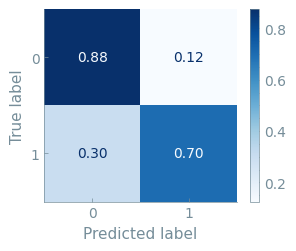

In [65]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_compSensors_confusionMatrix_70_30_size45_XGBoost.pdf', bbox_inches='tight')